# From MPC Orbit to N-Body Simulation with Rebound

#### This tutorial demonstrates how to take an orbit from the MPC's Orbits API and use it in an N-body simulation.

We will:
1. Fetch the orbit of the TNO Sedna from the MPC Orbits API
2. Parse it with the `mpc_orb` Python package to access Cartesian elements and the covariance matrix
3. Sample "orbital clones" from the covariance matrix to represent orbital uncertainty
4. Set up a Rebound N-body simulation with the Sun, planets, and our asteroid clones
5. Integrate forward for 10 million years and plot the orbital evolution

This workflow connects MPC data products directly to the widely-used [Rebound](https://rebound.readthedocs.io/) dynamical simulation package.

Further information:
- [MPC Orbits API documentation](https://docs.minorplanetcenter.net/mpc-ops-docs/apis/get-orb/)
- [mpc_orb Python package](https://github.com/Smithsonian/mpc-public/tree/main/mpc_orb)
- [Rebound documentation](https://rebound.readthedocs.io/)

## Environment Setup

This notebook requires `rebound`, `mpc-orb`, `astropy`, `matplotlib`, `numpy`, `tqdm`, and `requests`. We recommend creating a dedicated conda environment and registering it as a Jupyter kernel so that all dependencies are isolated and reproducible.

Run the following commands once in a terminal before opening this notebook:

```bash
# Create and populate the environment
conda create -n orbit-tutorial python=3.11 -y
conda activate orbit-tutorial
pip install rebound mpc-orb astropy matplotlib numpy tqdm requests ipykernel

# Register the environment as a Jupyter kernel
python -m ipykernel install --user --name orbit-tutorial --display-name "Python (orbit-tutorial)"
```

Then, in Jupyter, select **Kernel > Change Kernel > Python (orbit-tutorial)** before running the cells below.

# Install and Import Packages

We need `rebound` for the N-body simulation, `mpc-orb` for parsing MPC orbit data, and `astropy` for time conversions.

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import rebound
from mpc_orb.parse import MPCORB
from astropy.time import Time
from tqdm import tqdm


# Step 1: Fetch and Parse the Orbit

We query the MPC Orbits API for Sedna, a well-known TNO, and parse the result with `mpc_orb`. 

The `MPCORB` class provides structured access to orbital elements, uncertainties, covariance matrices, and metadata.

In [4]:
# Fetch the orbit of Sedna from the MPC
object_name = "Sedna"
response = requests.get(
    "https://data.minorplanetcenter.net/api/get-orb",
    json={"desig": object_name}
)
response.raise_for_status()
mpc_orb_dict = response.json()[0]['mpc_orb'][0]

# Parse with mpc_orb
M = MPCORB(mpc_orb_dict)

# Display basic information
print(f"Object Designation Data:")
pprint(M.designation_data, indent=2, depth=2 )
print(f"Epoch (MJD): {M.epoch_data['epoch']}")
print(f"Time system: {M.epoch_data['timesystem']}")
print()

# Display Cartesian elements with uncertainties
print("Cartesian orbital elements (AU, AU/day):")
print(f"{'Name':<6} {'Value':>20} {'Uncertainty':>16}")
print("-" * 44)
for name, val, unc in zip(
    M.CAR.coefficient_names,
    M.CAR.coefficient_values,
    M.CAR.coefficient_uncertainties
):
    print(f"{name:<6} {val:>20.15f} {unc:>16.6e}")

Object Designation Data:
{ 'citation': '(90377) Sedna = 2003 VB12<br><br>Sedna is the Inuit goddess of '
              'the sea and the mother of all sea creatures. She rewards the '
              'people of the land with food from the sea. Without her '
              'blessing, hunts fail and the people starve. She is thus one of '
              'the most important figures in Inuit legend. ',
  'designation_count': 1,
  'iau_name': '',
  'name': 'Sedna',
  'orbfit_name': '90377',
  'packed_primary_provisional_designation': 'K03V12B',
  'packed_secondary_provisional_designations': [],
  'permid': '90377',
  'unpacked_primary_provisional_designation': '2003 VB12',
  'unpacked_secondary_provisional_designations': []}
Epoch (MJD): 61000.0
Time system: TDT

Cartesian orbital elements (AU, AU/day):
Name                  Value      Uncertainty
--------------------------------------------
x        39.500123133868897     1.351020e-04
y        71.045083701809901     2.399870e-04
z       -17.059

# Step 2: Examine the Covariance Matrix

The `mpc_orb` package reconstructs the full symmetric covariance matrix from the stored lower-triangular elements. This matrix encodes the correlations between all orbital parameters.

We verify the matrix is positive-definite by checking that all eigenvalues are positive.

In [5]:
# Full covariance matrix (already assembled by mpc_orb)
cov_full = M.CAR.covariance_array
print(f"Covariance matrix shape: {cov_full.shape}")
print()
print("Covariance matrix:")
np.set_printoptions(precision=4, linewidth=120)
print(cov_full)
print()

# Compute eigenvalues to verify positive-definiteness
eigenvalues = np.linalg.eigvalsh(cov_full)
print("Eigenvalues of covariance matrix:")
for i, ev in enumerate(eigenvalues):
    print(f"  lambda_{i} = {ev:.6e}")

# Sanity check: all eigenvalues must be positive for a valid covariance matrix
assert np.all(eigenvalues > 0), "Covariance matrix is not positive-definite!"
print("\nAll eigenvalues positive: covariance matrix is valid.")

Covariance matrix shape: (6, 6)

Covariance matrix:
[[ 1.8253e-08  3.2373e-08 -7.8984e-09 -2.9356e-14  1.7614e-12 -3.1995e-13]
 [ 3.2373e-08  5.7594e-08 -1.4042e-08 -2.0778e-13  2.9579e-12 -5.2034e-13]
 [-7.8984e-09 -1.4042e-08  3.4457e-09  4.3914e-14 -7.2821e-13  1.3413e-13]
 [-2.9356e-14 -2.0778e-13  4.3914e-14  2.4902e-16  2.9151e-16 -7.9405e-17]
 [ 1.7614e-12  2.9579e-12 -7.2821e-13  2.9151e-16  5.2260e-16 -1.2586e-16]
 [-3.1995e-13 -5.2034e-13  1.3413e-13 -7.9405e-17 -1.2586e-16  3.2948e-17]]

Eigenvalues of covariance matrix:
  lambda_0 = 1.491403e-19
  lambda_1 = 3.993476e-19
  lambda_2 = 3.197831e-16
  lambda_3 = 2.044994e-11
  lambda_4 = 4.240028e-11
  lambda_5 = 7.922912e-08

All eigenvalues positive: covariance matrix is valid.


# Step 3: Sample Orbital Clones


To represent the orbital uncertainty, we draw samples from a multivariate normal distribution where:
- The **mean** is the nominal (best-fit) orbit
- The **covariance** defines the uncertainty ellipsoid in 6D phase space

Though MPC orbit fits currently do not explicitly reference a prior (and therefore implicitly use flat priors), the mean and covariance matrix can be interpreted as the Gaussian approximation of the posterior distribution for the orbital elements. Thus samples drawn from this distribution ("clones") each represent a statistically plausible orbit, and by propagating a distribution of samples, we can quantify how the orbital uncertainty grows over time. Since more clones will be drawn from near the mean than towards the edges, the on-sky density of clones at any time is proportional to the likelihood of finding Sedna in that region

In [6]:
# Use only the 6 position/velocity components (x, y, z, vx, vy, vz)
mean = np.array(M.CAR.coefficient_values[:6])
cov = cov_full[:6, :6]

# Sample 100 orbital clones
n_clones = 100
np.random.seed(42)  # For reproducibility
clones = np.random.multivariate_normal(mean, cov, n_clones)

# Display the nominal orbit and clones
names = M.CAR.coefficient_names[:6]
print(f"{'':>10}", end="")
for name in names:
    print(f"{name:>20}", end="")
print()
print("-" * 130)

print(f"{'Nominal':>10}", end="")
for v in mean:
    print(f"{v:>20.15f}", end="")
print()

for i, clone in enumerate(clones):
    print(f"{'Clone ' + str(i):>10}", end="")
    for v in clone:
        print(f"{v:>20.15f}", end="")
    print()

                             x                   y                   z                  vx                  vy                  vz
----------------------------------------------------------------------------------------------------------------------------------
   Nominal  39.500123133868897  71.045083701809901 -17.059777137478701  -0.002486517552993   0.000602970985653   0.000201474545227
   Clone 0  39.500055061295633  71.044964381095539 -17.059750948143776  -0.002486535047046   0.000602941585839   0.000201481116801
   Clone 1  39.499914508397133  71.044702727682989 -17.059682511127708  -0.002486513307365   0.000602954044219   0.000201477927934
   Clone 2  39.500080224057399  71.045033195739634 -17.059755632371782  -0.002486533744880   0.000602951551896   0.000201482429683
   Clone 3  39.500237125194928  71.045304786723136 -17.059836978601542  -0.002486532953466   0.000602966821794   0.000201474994355
   Clone 4  39.500197670872666  71.045214986285615 -17.059803895405572  -0.00248652

# Step 4: Set Up the Rebound Simulation

We create a Rebound simulation at the MPC orbit epoch containing:
- The Sun and 4 planets (loaded from JPL Horizons)
- The nominal orbit of Sedna as a massless test particle
- 100 orbital clones as additional test particles

**Unit handling:** MPC Cartesian elements use AU for positions and AU/day for velocities. We set `sim.units = ('AU', 'day', 'Msun')` so that Rebound and Horizons use the same units. This ensures we can directly insert MPC state vectors without any conversion.

We use the WHFast symplectic integrator, which is efficient for long-term integrations. 

The timestep is set to 1/20th of Jupiters's orbital period for accuracy.

NB: It is possible that you may experience the following error when adding planets to rebound (which uses the NASA Horizons system to extract the planetary positions): `RuntimeError: An error occured while accessing NASA HORIZONS. If this is a SSL certificate issue, you can try disabling the certificate verification by setting rebound.horizons.SSL_CONTEXT = 'unverified'.`
 - In this scenario, the simplest approach is to just retry the evaluation, and this typically will succeed. 

In [7]:
# Convert MPC epoch (MJD) to a date string for Horizons
epoch_mjd = M.epoch_data['epoch']
epoch_date = Time(epoch_mjd, format='mjd').iso[:10]  # YYYY-MM-DD
print(f"Epoch: MJD {epoch_mjd} = {epoch_date}")

# Create the simulation with AU/day/Msun units to match MPC data
sim = rebound.Simulation()
sim.units = ('AU', 'day', 'Msun')

# Add the Sun and planets from Horizons at the MPC epoch
bodies = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"] # "Mercury", "Venus", "Earth", "Mars",
for body in bodies:
    sim.add(body, date=epoch_date)
    print(f"Added {body}")

# Add the nominal orbit as a test particle (mass=0)
sim.add(x=mean[0], y=mean[1], z=mean[2],
        vx=mean[3], vy=mean[4], vz=mean[5])
print(f"Added nominal {object_name} orbit")

# Add the clones as test particles
for i, clone in enumerate(clones):
    sim.add(x=clone[0], y=clone[1], z=clone[2],
            vx=clone[3], vy=clone[4], vz=clone[5])
print(f"Added {n_clones} orbital clones")

# Configure the integrator
sim.integrator = "whfast"
sim.dt = sim.particles[1].P / 20.0  # 1/20 of inner-most planet's orbital period
sim.move_to_com()

# Verify the nominal orbit looks correct
orb = sim.particles[9].orbit(primary=sim.particles[0])
print(f"\nNominal {object_name} orbit check: a={orb.a:.4f} AU, e={orb.e:.4f}, inc={np.degrees(orb.inc):.2f} deg")
print(f"Total particles: {sim.N} (Sun + 8 planets + 1 nominal + {n_clones} clones)")
print(f"Integrator: {sim.integrator}")
print(f"Timestep: {sim.dt:.4f} days ({sim.dt/365.25:.6f} years)")

Epoch: MJD 61000.0 = 2025-11-21
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Added Sun
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Added Jupiter
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Added Saturn
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Added Uranus
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
Added Neptune
Added nominal Sedna orbit
Added 100 orbital clones

Nominal Sedna orbit check: a=590.4016 AU, e=0.8709, inc=11.92 deg
Total particles: 106 (Sun + 8 planets + 1 nominal + 100 clones)
Integrator: whfast
Timestep: 216.6078 days (0.593040 years)


# Step 5: Run the Simulation

We integrate the system forward for 10 million years, recording the semi-major axis, eccentricity, and inclination of the nominal orbit and each clone at 1,000 evenly-spaced output times.

**Note:** This integration may take a few minutes depending on your machine.

In [8]:
# Integration parameters
t_final = 10.0e6 * 365.25  # 10 million years in days
n_outputs = 1000
times = np.linspace(0, t_final, n_outputs)

# Indices of test particles: nominal is after Sun + planets, clones after that ... 
i_nominal = len(bodies)
i_first_clone = i_nominal + 1 
i_clones = list(range(i_first_clone, i_first_clone + n_clones))
all_test = [i_nominal] + i_clones
n_test = len(all_test)

# Storage arrays
a_arr = np.zeros((n_outputs, n_test))
e_arr = np.zeros((n_outputs, n_test))
inc_arr = np.zeros((n_outputs, n_test))

# Integrate
for k, t in enumerate(tqdm(times)):
    
    sim.integrate(t)
    for j, idx in enumerate(all_test):
        orb = sim.particles[idx].orbit(primary=sim.particles[0])
        a_arr[k, j] = orb.a
        e_arr[k, j] = orb.e
        inc_arr[k, j] = np.degrees(orb.inc)

print("Integration complete.")

# Convert times to years for plotting
times_yr = times / 365.25

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:27<00:00,  1.59it/s]

Integration complete.


# Step 6: Plot the Results

We have saved the data into arrays, `a_arr`, `e_arr` & `inc_arr` that have shape `(1,000, n_clones+1)`, such that we have 1,000 data points for the nominal orbit in, e.g.,  `a_arr[:,0]`, and then 1,000 data points for each of the clones in , e.g., `a_arr[:,1:]`.

We use these arrays to plot the orbital evolution of the nominal orbit (red, bold) and the clones (gray, transparent), showing how the orbital uncertainty spreads over 10 million years.

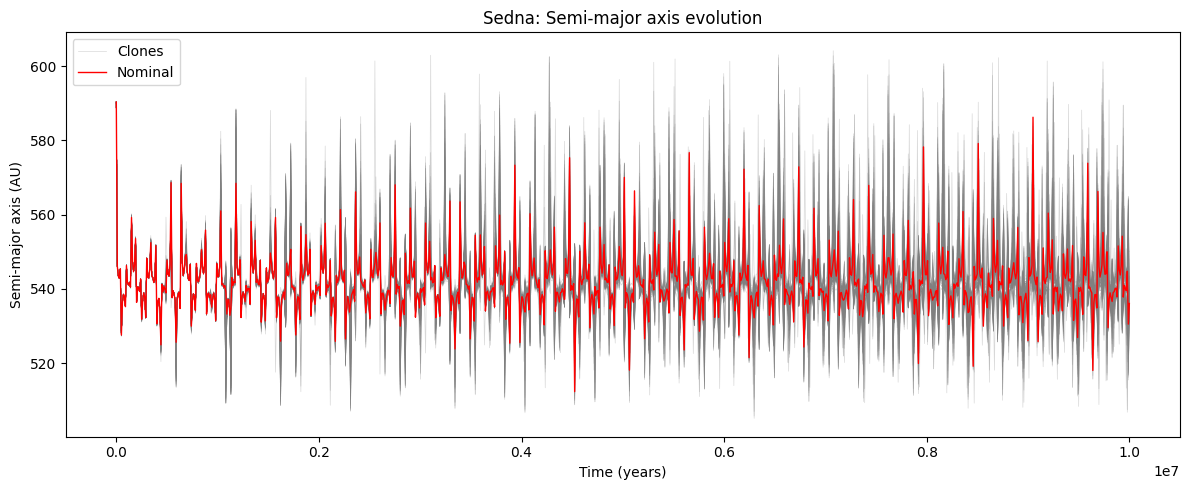

In [9]:
# Semi-major axis vs time
fig, ax = plt.subplots(figsize=(12, 5))

for j in range(1, n_test):  # clones
    ax.plot(times_yr, a_arr[:, j], color='gray', linewidth=0.5, alpha=0.3, label=f'Clones' if j == 1 else None )
ax.plot(times_yr, a_arr[:, 0], color='red', linewidth=1.0, label='Nominal')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Semi-major axis (AU)')
ax.set_title(f'{object_name}: Semi-major axis evolution')
ax.legend()
plt.tight_layout()
plt.show()

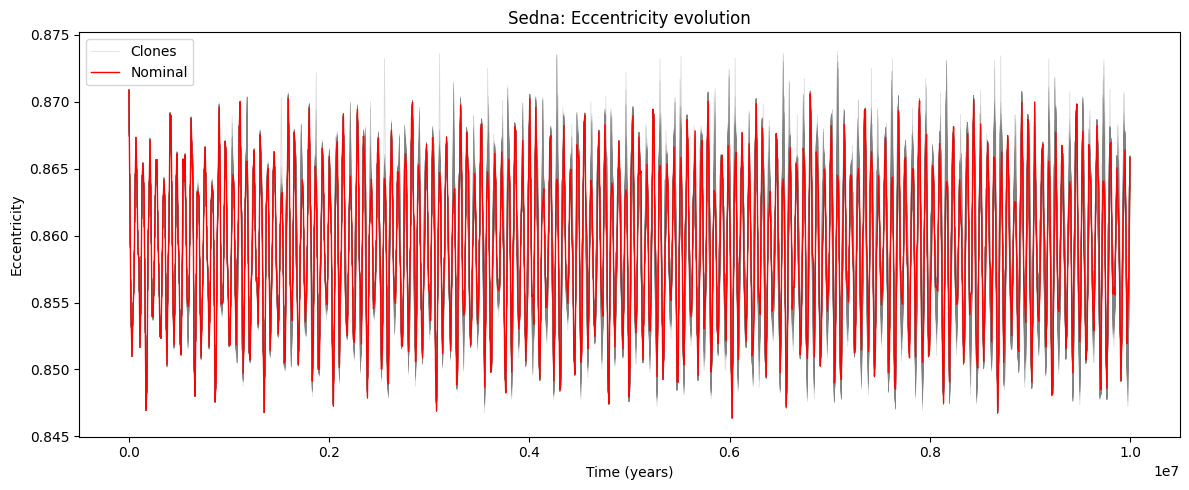

In [10]:
# Eccentricity vs time
fig, ax = plt.subplots(figsize=(12, 5))

for j in range(1, n_test):  # clones
    ax.plot(times_yr, e_arr[:, j], color='gray', linewidth=0.5, alpha=0.3, label=f'Clones' if j == 1 else None )
ax.plot(times_yr, e_arr[:, 0], color='red', linewidth=1.0, label='Nominal')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Eccentricity')
ax.set_title(f'{object_name}: Eccentricity evolution')
ax.legend()
plt.tight_layout()
plt.show()

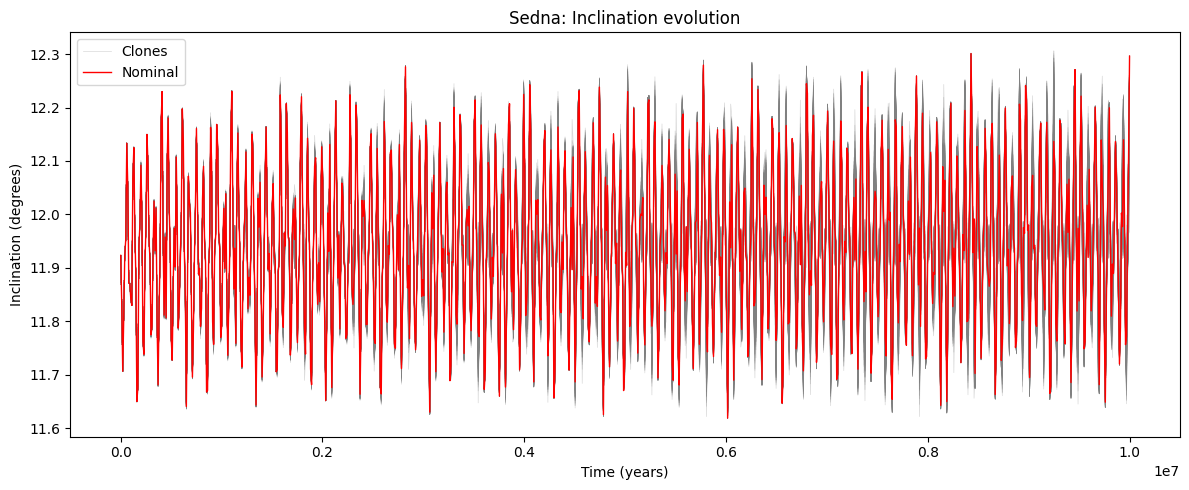

In [11]:
# Inclination vs time
fig, ax = plt.subplots(figsize=(12, 5))

for j in range(1, n_test):  # clones
    ax.plot(times_yr, inc_arr[:, j], color='gray', linewidth=0.5, alpha=0.3, label=f'Clones' if j == 1 else None )
ax.plot(times_yr, inc_arr[:, 0], color='red', linewidth=1.0, label='Nominal')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Inclination (degrees)')
ax.set_title(f'{object_name}: Inclination evolution')
ax.legend()
plt.tight_layout()
plt.show()

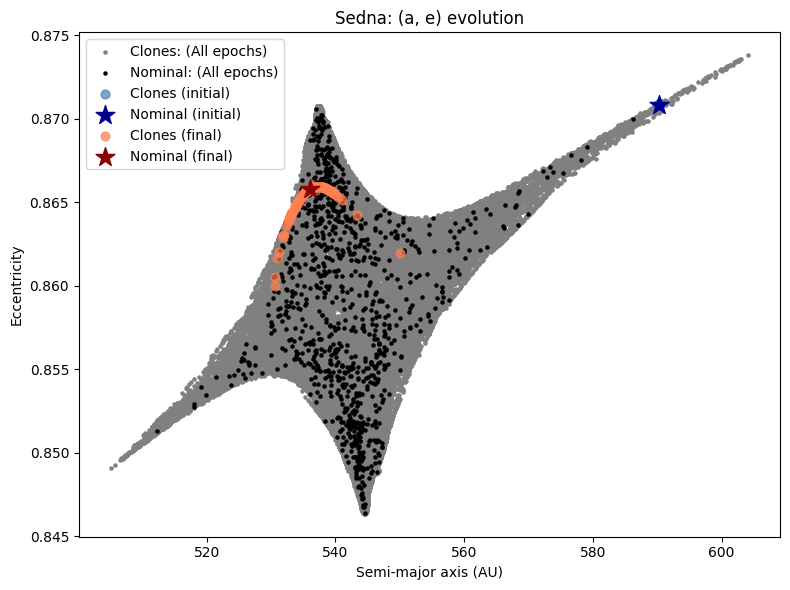

In [12]:
# (a, e) scatter: initial vs final epoch
fig, ax = plt.subplots(figsize=(8, 6))

# All epochs 
ax.scatter(a_arr[:,1:], e_arr[:,1:], color='gray', marker='.', s=20, label='Clones: (All epochs)', zorder=0)
ax.scatter(a_arr[:,0], e_arr[:,0], color='black', marker='.', s=20, label='Nominal: (All epochs)', zorder=1)

# Initial epoch (first output)
ax.scatter(a_arr[0, 1:], e_arr[0, 1:], color='steelblue', alpha=0.7, s=40, label='Clones (initial)', zorder=2)
ax.scatter(a_arr[0, 0], e_arr[0, 0], color='darkblue', marker='*',s=200, label='Nominal (initial)', zorder=3)

# Final epoch (last output)
ax.scatter(a_arr[-1, 1:], e_arr[-1, 1:], color='coral', alpha=0.7,s=40, label='Clones (final)', zorder=2)
ax.scatter(a_arr[-1, 0], e_arr[-1, 0], color='darkred', marker='*',s=200, label='Nominal (final)', zorder=3)



ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_title(f'{object_name}: (a, e) evolution')
ax.legend()
plt.tight_layout()
plt.show()

# Summary

In this tutorial we:

1. **Fetched** the orbit of Sedna from the MPC Orbits API
2. **Parsed** it with the `mpc_orb` package to access Cartesian state vectors and the full covariance matrix
3. **Sampled** 100 orbital clones from the covariance matrix using multivariate normal sampling
4. **Built** a Rebound N-body simulation with the Sun, 4 planets, and all test particles
5. **Integrated** the system forward for 10 million years using the WHFast symplectic integrator
6. **Plotted** the orbital evolution to visualize how uncertainty propagates over time

The spread of the clones over time shows how even small uncertainties in the initial orbit can lead to divergent trajectories over long timescales.

### Further Resources

- [MPC Orbits API documentation](https://docs.minorplanetcenter.net/mpc-ops-docs/apis/get-orb/)
- [mpc_orb Python package](https://github.com/Smithsonian/mpc-public/tree/main/mpc_orb)
- [Rebound documentation](https://rebound.readthedocs.io/)
- [Rein & Liu 2012 (WHFast)](https://ui.adsabs.harvard.edu/abs/2012A%26A...537A.128R)

For questions or feedback, contact the MPC via the [Jira Helpdesk](https://mpc-service.atlassian.net/servicedesk/customer/portal/13/create/148).